In [123]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [124]:
heart_dataset = pd.read_csv('heart.csv')

In [125]:
heart_dataset.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [126]:
df_columns = list(heart_dataset.columns)
df_columns

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

In [127]:
heart_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [128]:
object_columns = []
for x in df_columns:
    if heart_dataset[x].dtype == 'object':
        print(x)
        object_columns.append(x)

Sex
ChestPainType
RestingECG
ExerciseAngina
ST_Slope


In [129]:
for column in object_columns:
    unique_values = heart_dataset[column].unique()

    mapping = {val: i for i, val in enumerate(unique_values)}
    heart_dataset[column] = heart_dataset[column].map(mapping)


In [130]:
heart_dataset

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,0,140,289,0,0,172,0,0.0,0,0
1,49,1,1,160,180,0,0,156,0,1.0,1,1
2,37,0,0,130,283,0,1,98,0,0.0,0,0
3,48,1,2,138,214,0,0,108,1,1.5,1,1
4,54,0,1,150,195,0,0,122,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,0,3,110,264,0,0,132,0,1.2,1,1
914,68,0,2,144,193,1,0,141,0,3.4,1,1
915,57,0,2,130,131,0,0,115,1,1.2,1,1
916,57,1,0,130,236,0,2,174,0,0.0,1,1


In [131]:
X = heart_dataset.drop(columns=['HeartDisease']).values
y = heart_dataset['HeartDisease'].values


X = torch.tensor(X, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.float32)

print(X.shape)
print(y.shape)


from torch.utils.data import TensorDataset

heart_dataset_tensor = TensorDataset(X,y)
print(heart_dataset_tensor)

torch.Size([918, 11])
torch.Size([918])


In [132]:
#defining test, train and validation sets

from torch.utils.data import random_split

train_size = int(0.8 * len(heart_dataset_tensor))
val_size = int(0.1 * len(heart_dataset_tensor))

test_size = len(heart_dataset_tensor) - train_size - val_size

train_dataset, validation_dataset, test_dataset = random_split(heart_dataset_tensor, [train_size,val_size, test_size])




In [133]:
#split Datset into batches
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

#num of batches
print(len(train_loader))
print(len(validation_loader))
print(len(test_loader))

23
3
3


In [134]:
import torch.nn as nn

class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(11,33)
        self.relu = nn.ReLU()
        self.output = nn.Linear(33,1)   

    def forward(self,x):
        x = self.relu(self.hidden(x))
        x = self.output(x)
        return x

In [135]:
model = Wide()
print(sum([x.reshape(-1).shape[0] for x in model.parameters()]))

430


In [136]:
#creating the Loss function
# using pytorch's cross entropy loss function just cuz its good at binary classification

loss_fn = nn.BCEWithLogitsLoss()

#Use loss_fn(outputs,labels)

In [137]:
#optimizer - Scholastic Gradient Descent:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [138]:
#training loop function

def train_one_epoch(epoch_index, tb_writer):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data

        #resets the optimizer after every gradient descent
        optimizer.zero_grad()

        #makes predictions:
        outputs = model(inputs)

        #usign the loss function, computing the loss and the gradients:
        loss = loss_fn(outputs, labels.unsqueeze(1).float())

        loss.backward()
        
        #adjust the learning weights:
        optimizer.step()

        #report the data
        running_loss += loss.item()
        
    avg_loss = running_loss/ len(train_loader)
    tb_writer.add_scalar('Loss/train', avg_loss,epoch_index)
    return avg_loss 


Epoch1.0:
Loss train 5.1005206989205405 valid 1.9838128884633381
Epoch2.0:
Loss train 1.337275152621062 valid 0.9815406004587809
Epoch3.0:
Loss train 0.9714436038680698 valid 0.775196373462677
Epoch4.0:
Loss train 0.8331042061681333 valid 0.7055231332778931
Epoch5.0:
Loss train 0.7739947205004485 valid 0.6673070987065634
Epoch6.0:
Loss train 0.7261023288187773 valid 0.6117784182230631
Epoch7.0:
Loss train 0.6824591030245242 valid 0.5789778927961985
Epoch8.0:
Loss train 0.6575205248335133 valid 0.5961584150791168
Epoch9.0:
Loss train 0.6259897156901981 valid 0.596755842367808
Epoch10.0:
Loss train 0.6157469425512396 valid 0.5791042447090149
Epoch11.0:
Loss train 0.5883506277333135 valid 0.5310630003611246
Epoch12.0:
Loss train 0.5797910055388575 valid 0.5130090614159902
Epoch13.0:
Loss train 0.5557106811067333 valid 0.5357214311758677
Epoch14.0:
Loss train 0.5539874421513599 valid 0.4774715503056844
Epoch15.0:
Loss train 0.5549245476722717 valid 0.4686953624089559
Epoch16.0:
Loss train 

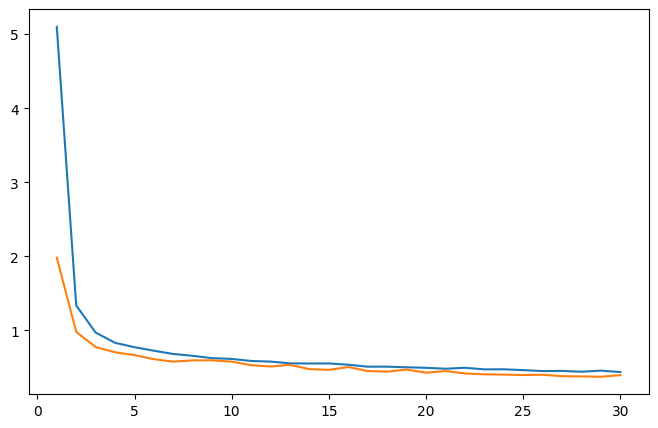

In [139]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/heart_disease_classfication_trainer')
import matplotlib.pyplot as plt

#training Loop
epoch_number = 0.
EPOCHS = 30

avg_loss_lst = []
avg_vloss_lst = []

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('Epoch{}:'.format(epoch_number + 1) )


    model.train(True)
    avg_loss = train_one_epoch(epoch_number,writer)

    running_vloss = 0.
    model.eval()

    #disable gradient computation to save memory:
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels.unsqueeze(1).float())
            running_vloss += vloss.item()
    avg_vloss = running_vloss/(i+1)
    print('Loss train {} valid {}'.format(avg_loss,avg_vloss))

    avg_loss_lst.append(avg_loss)
    avg_vloss_lst.append(avg_vloss)

    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation':avg_vloss},
                       epoch_number+1)
    writer.flush()

    if avg_loss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}'.format(epoch_number)
        torch.save(model.state_dict(),model_path)

    epoch_number += 1 

plt.figure(figsize=(8,5))
plt.plot(range(1,EPOCHS+1), avg_loss_lst, label="training Loss")
plt.plot(range(1,EPOCHS+1), avg_vloss_lst, label='Validation Loss')
plt.show()

In [141]:
#testing the model

model.load_state_dict(torch.load('model_25.0'))
model.eval()

Wide(
  (hidden): Linear(in_features=11, out_features=33, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=33, out_features=1, bias=True)
)

In [143]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        all_preds.extend(preds.squeeze().tolist())
        all_labels.extend(labels.tolist())

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(all_labels, all_preds)
print(accuracy)